In [20]:
# 필요한 패키지 설치
%pip install pandas numpy matplotlib seaborn openpyxl scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [21]:
# 데이터 전처리를 위한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. ECOS 경제 데이터 전처리

ECOS(한국은행 경제통계시스템)에서 수집한 경제 지표 데이터를 전처리합니다.

In [22]:
# ECOS 통합 데이터 로드
ecos_file_path = "../ecos/economic_data_merged.csv"

try:
    ecos_data = pd.read_csv(ecos_file_path, encoding='utf-8-sig')
    print(f"ECOS 데이터 로드 완료: {ecos_data.shape}")
    print("\n컬럼 정보:")
    print(ecos_data.columns.tolist())
    print("\n데이터 미리보기:")
    ecos_data.head()
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {ecos_file_path}")
    print("경로를 확인해주세요.")

ECOS 데이터 로드 완료: (120, 20)

컬럼 정보:
['date', 'base_rate', 'ccsi', 'construction_bsi_actual', 'construction_bsi_forecast', 'cpi', 'esi', 'exchange_usd_원_달러종가_15_30', 'housing_lease_price', 'housing_sale_price', 'import_price_비금속광물', 'import_price_철강1차제품', 'leading_index', 'm2_growth', 'market_rate_국고채10년', 'market_rate_국고채3년', 'market_rate_회사채3년_AA_', 'market_rate_회사채3년_BBB_', 'ppi_비금속광물', 'ppi_철강1차제품']

데이터 미리보기:


In [23]:
# ECOS 데이터 기본 정보 확인
if 'ecos_data' in locals():
    print("=== ECOS 데이터 기본 정보 ===")
    print(f"데이터 형태: {ecos_data.shape}")
    print(f"메모리 사용량: {ecos_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print("\n=== 데이터 타입 ===")
    print(ecos_data.dtypes)
    
    print("\n=== 결측값 확인 ===")
    print(ecos_data.isnull().sum())
    
    print("\n=== 수치형 컬럼 기본 통계 ===")
    print(ecos_data.describe())

=== ECOS 데이터 기본 정보 ===
데이터 형태: (120, 20)
메모리 사용량: 0.02 MB

=== 데이터 타입 ===
date                           int64
base_rate                    float64
ccsi                         float64
construction_bsi_actual      float64
construction_bsi_forecast      int64
cpi                          float64
esi                          float64
exchange_usd_원_달러종가_15_30    float64
housing_lease_price          float64
housing_sale_price           float64
import_price_비금속광물           float64
import_price_철강1차제품          float64
leading_index                float64
m2_growth                    float64
market_rate_국고채10년           float64
market_rate_국고채3년            float64
market_rate_회사채3년_AA_        float64
market_rate_회사채3년_BBB_       float64
ppi_비금속광물                    float64
ppi_철강1차제품                   float64
dtype: object

=== 결측값 확인 ===
date                         0
base_rate                    2
ccsi                         1
construction_bsi_actual      1
construction_bsi_forecast    0
c

In [24]:
# ECOS 데이터 날짜 전처리 - 월말일로 변경
if 'ecos_data' in locals():
    print("=== 날짜 컬럼 전처리 ===")
    
    # 날짜 컬럼 확인
    date_columns = [col for col in ecos_data.columns if 'date' in col.lower() or 'time' in col.lower()]
    print(f"날짜 관련 컬럼: {date_columns}")
    
    # 날짜 컬럼이 있다면 datetime으로 변환하고 월말일로 설정
    if date_columns:
        for col in date_columns:
            try:
                # YYYYMM 형식을 datetime으로 변환 (월초로)
                if ecos_data[col].dtype == 'object' or ecos_data[col].dtype == 'int64':
                    ecos_data[col] = pd.to_datetime(ecos_data[col].astype(str), format='%Y%m')
                    print(f"{col} 컬럼을 datetime으로 변환 완료")
                
                # 월말일로 변경
                ecos_data[col] = ecos_data[col] + pd.offsets.MonthEnd(0)
                print(f"{col} 컬럼을 월말일로 변경 완료")
                
                # 날짜 범위 확인
                print(f"{col} 범위: {ecos_data[col].min()} ~ {ecos_data[col].max()}")
                
            except Exception as e:
                print(f"{col} 변환 실패: {e}")
    
    print("\n변환 후 데이터 타입:")
    print(ecos_data.dtypes)
    
    # 변경된 날짜 확인
    print("\n변경된 날짜 샘플:")
    print(ecos_data[['date']].head(10))

=== 날짜 컬럼 전처리 ===
날짜 관련 컬럼: ['date']
date 컬럼을 datetime으로 변환 완료
date 컬럼을 월말일로 변경 완료
date 범위: 2015-10-31 00:00:00 ~ 2025-09-30 00:00:00

변환 후 데이터 타입:
date                         datetime64[ns]
base_rate                           float64
ccsi                                float64
construction_bsi_actual             float64
construction_bsi_forecast             int64
cpi                                 float64
esi                                 float64
exchange_usd_원_달러종가_15_30           float64
housing_lease_price                 float64
housing_sale_price                  float64
import_price_비금속광물                  float64
import_price_철강1차제품                 float64
leading_index                       float64
m2_growth                           float64
market_rate_국고채10년                  float64
market_rate_국고채3년                   float64
market_rate_회사채3년_AA_               float64
market_rate_회사채3년_BBB_              float64
ppi_비금속광물                           float64
ppi_철강1차제품      

In [25]:
# ECOS 데이터 기간 조정 - 현재 달 제외하고 직전 달까지만 사용
if 'ecos_data' in locals():
    print("=== ECOS 데이터 기간 조정 ===")
    
    # 현재 날짜 기준으로 직전 달의 마지막 날 계산
    from datetime import datetime
    import pandas as pd
    
    current_date = datetime.now()
    # 현재 달의 첫째 날에서 하루 빼면 전월 마지막 날
    last_month_end = pd.Timestamp(current_date.year, current_date.month, 1) - pd.Timedelta(days=1)
    
    print(f"현재 날짜: {current_date.strftime('%Y-%m-%d')}")
    print(f"사용할 데이터 마지막 날짜: {last_month_end.strftime('%Y-%m-%d')}")
    
    # 데이터 필터링
    original_shape = ecos_data.shape
    ecos_data_filtered = ecos_data[ecos_data['date'] <= last_month_end].copy()
    
    print(f"원본 데이터: {original_shape}")
    print(f"필터링 후: {ecos_data_filtered.shape}")
    print(f"제거된 행 수: {original_shape[0] - ecos_data_filtered.shape[0]}")
    
    # 데이터 기간 확인
    print(f"필터링 후 데이터 기간: {ecos_data_filtered['date'].min()} ~ {ecos_data_filtered['date'].max()}")
    
    # 필터링된 데이터를 메인 변수로 할당
    ecos_data = ecos_data_filtered

=== ECOS 데이터 기간 조정 ===
현재 날짜: 2025-09-03
사용할 데이터 마지막 날짜: 2025-08-31
원본 데이터: (120, 20)
필터링 후: (119, 20)
제거된 행 수: 1
필터링 후 데이터 기간: 2015-10-31 00:00:00 ~ 2025-08-31 00:00:00


## ECOS 데이터 시각화

주요 경제지표들의 시계열 변화를 시각화합니다.

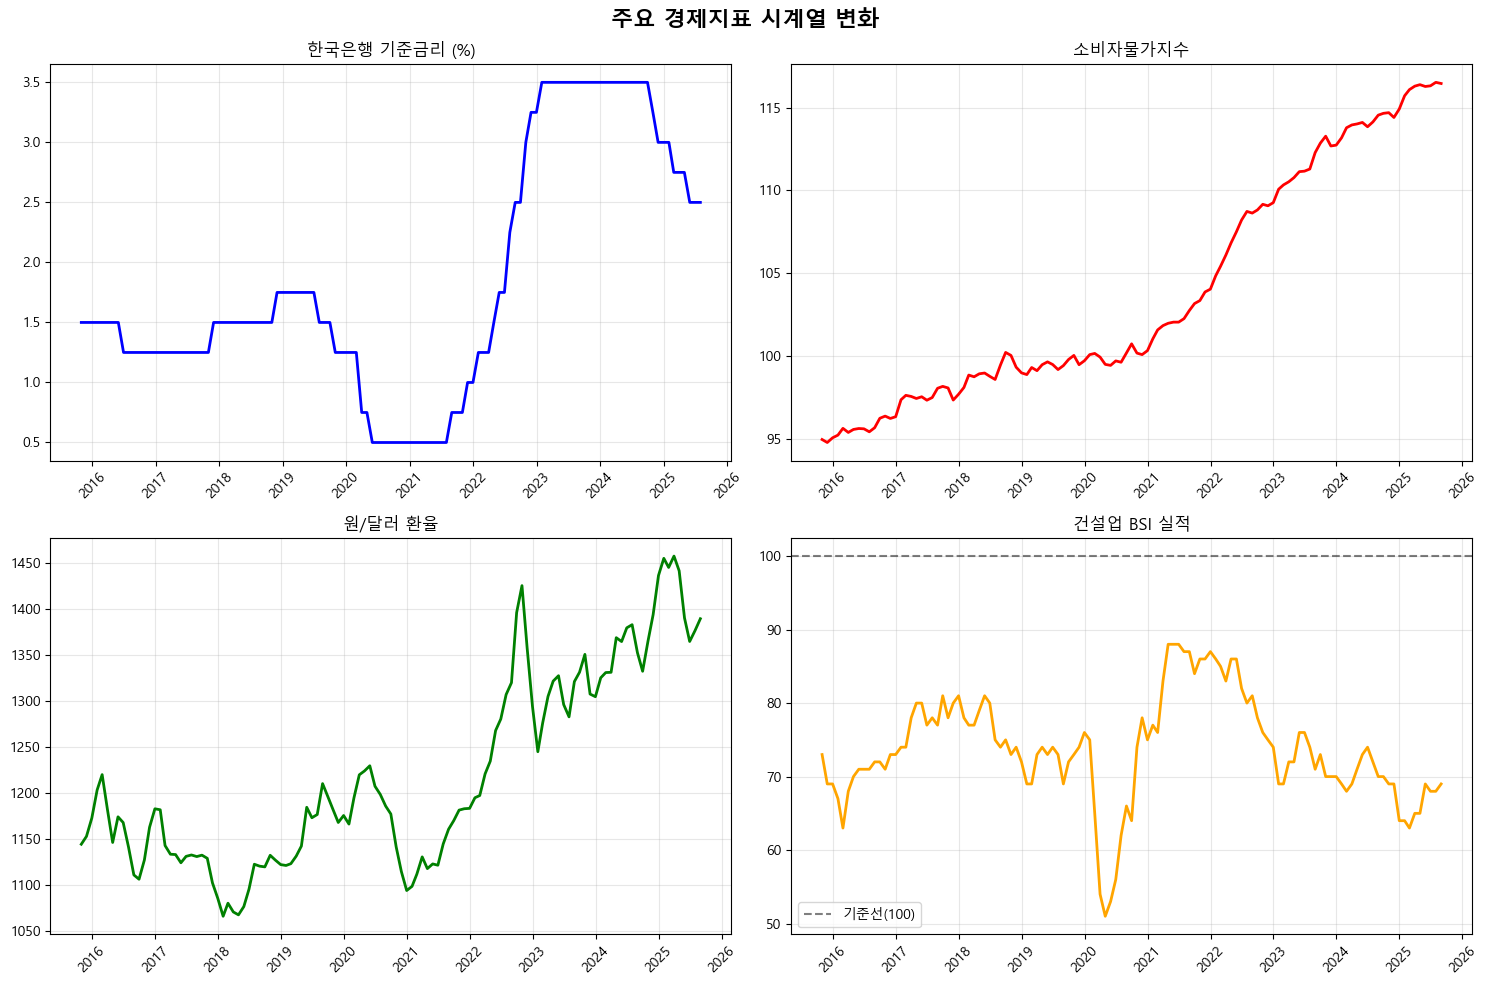

In [26]:
# 1. 주요 경제지표 시계열 그래프
if 'ecos_data' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('주요 경제지표 시계열 변화', fontsize=16, fontweight='bold')
    
    # 1) 기준금리
    axes[0, 0].plot(ecos_data['date'], ecos_data['base_rate'], color='blue', linewidth=2)
    axes[0, 0].set_title('한국은행 기준금리 (%)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2) 소비자물가지수
    axes[0, 1].plot(ecos_data['date'], ecos_data['cpi'], color='red', linewidth=2)
    axes[0, 1].set_title('소비자물가지수')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3) 원달러 환율
    axes[1, 0].plot(ecos_data['date'], ecos_data['exchange_usd_원_달러종가_15_30'], color='green', linewidth=2)
    axes[1, 0].set_title('원/달러 환율')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4) 건설업 BSI 실적
    axes[1, 1].plot(ecos_data['date'], ecos_data['construction_bsi_actual'], color='orange', linewidth=2)
    axes[1, 1].set_title('건설업 BSI 실적')
    axes[1, 1].axhline(y=100, color='black', linestyle='--', alpha=0.5, label='기준선(100)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

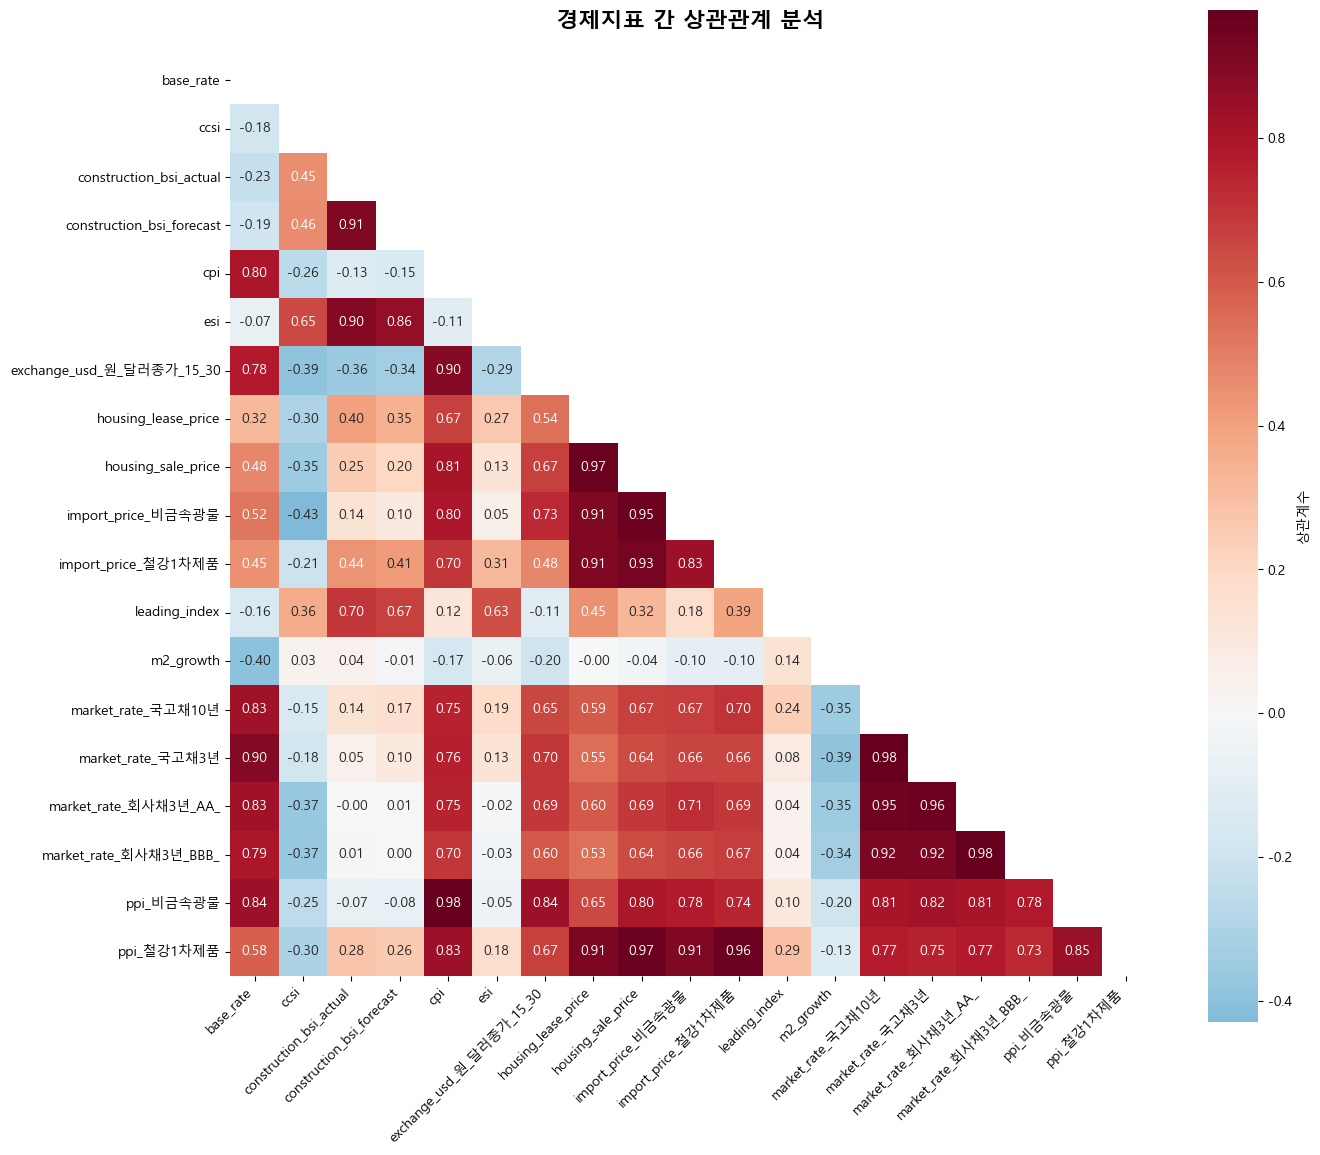

=== 건설업 BSI 실적과의 상관관계 ===
construction_bsi_actual      1.000000
construction_bsi_forecast    0.912037
esi                          0.895433
leading_index                0.701876
ccsi                         0.451163
import_price_철강1차제품          0.444805
housing_lease_price          0.399952
exchange_usd_원_달러종가_15_30    0.360765
ppi_철강1차제품                   0.277672
housing_sale_price           0.252087
Name: construction_bsi_actual, dtype: float64


In [27]:
# 2. 경제지표 간 상관관계 히트맵
if 'ecos_data' in locals():
    # 수치형 컬럼만 선택 (날짜 제외)
    numeric_cols = ecos_data.select_dtypes(include=[np.number]).columns
    correlation_matrix = ecos_data[numeric_cols].corr()
    
    plt.figure(figsize=(14, 12))
    
    # 히트맵 생성
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # 상삼각 마스크
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={'label': '상관계수'})
    
    plt.title('경제지표 간 상관관계 분석', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # 건설업 BSI와 높은 상관관계를 가진 지표들
    print("=== 건설업 BSI 실적과의 상관관계 ===")
    bsi_corr = correlation_matrix['construction_bsi_actual'].abs().sort_values(ascending=False)
    print(bsi_corr.head(10))

## ECOS 데이터 스케일링

머신러닝 모델 적용을 위해 데이터 스케일링을 수행합니다.

=== ECOS 데이터 스케일링 ===
스케일링 대상 컬럼: 19개
컬럼명: ['base_rate', 'ccsi', 'construction_bsi_actual', 'construction_bsi_forecast', 'cpi', 'esi', 'exchange_usd_원_달러종가_15_30', 'housing_lease_price', 'housing_sale_price', 'import_price_비금속광물', 'import_price_철강1차제품', 'leading_index', 'm2_growth', 'market_rate_국고채10년', 'market_rate_국고채3년', 'market_rate_회사채3년_AA_', 'market_rate_회사채3년_BBB_', 'ppi_비금속광물', 'ppi_철강1차제품']

결측값 현황:
base_rate              1
import_price_비금속광물     1
import_price_철강1차제품    1
leading_index          1
m2_growth              3
ppi_비금속광물              1
ppi_철강1차제품             1
dtype: int64

결측값을 forward fill로 처리합니다.

스케일링 완료!
원본 데이터 통계:
       base_rate    ccsi  construction_bsi_actual  construction_bsi_forecast  \
count     119.00  119.00                   119.00                     119.00   
mean        1.84   89.56                    73.68                      74.25   
std         1.01    3.65                     7.25                       7.35   
min         0.50   77.00      

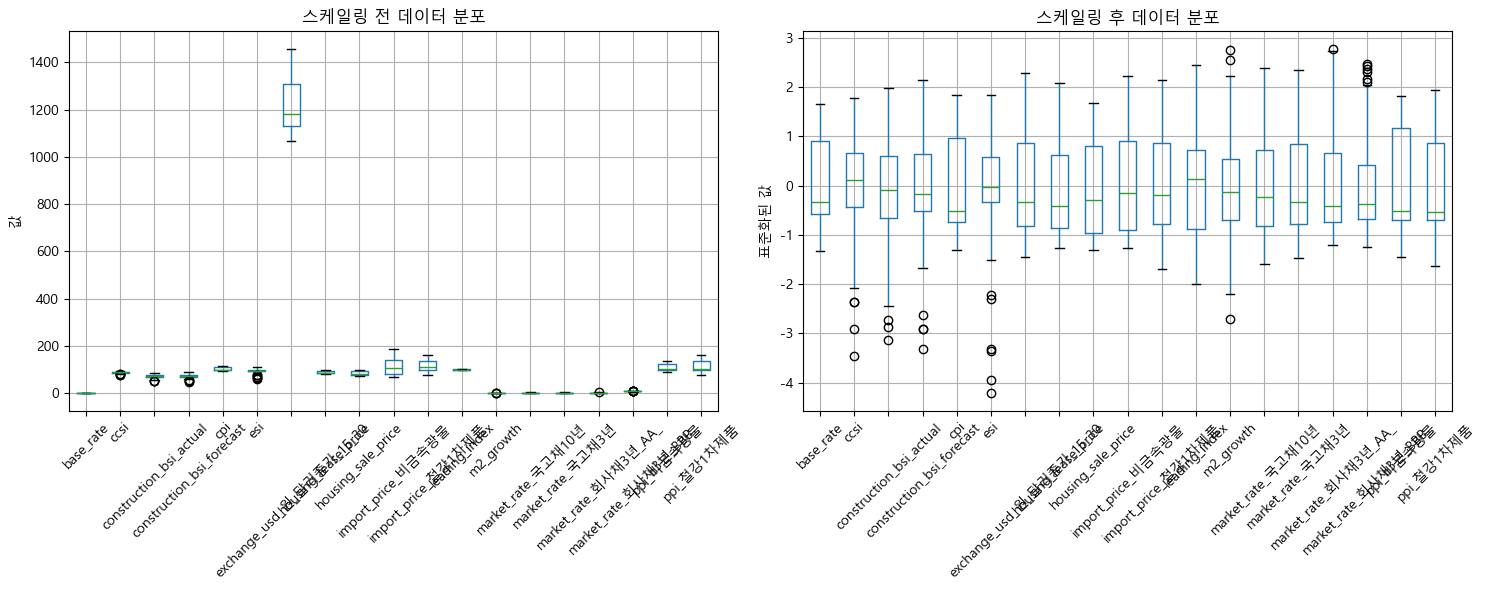


스케일링된 데이터 형태: (119, 20)
스케일링된 데이터를 'ecos_scaled_df' 변수에 저장했습니다.


In [28]:
# StandardScaler를 사용한 데이터 스케일링
from sklearn.preprocessing import StandardScaler
import pandas as pd

if 'ecos_data' in locals():
    print("=== ECOS 데이터 스케일링 ===")
    
    # 날짜 컬럼 분리
    date_col = ecos_data['date'].copy()
    
    # 수치형 컬럼만 선택
    numeric_cols = ecos_data.select_dtypes(include=[np.number]).columns
    numeric_data = ecos_data[numeric_cols].copy()
    
    print(f"스케일링 대상 컬럼: {len(numeric_cols)}개")
    print(f"컬럼명: {list(numeric_cols)}")
    
    # 결측값 확인
    print(f"\n결측값 현황:")
    missing_counts = numeric_data.isnull().sum()
    print(missing_counts[missing_counts > 0])
    
    # 결측값이 있다면 처리 (forward fill 사용)
    if numeric_data.isnull().any().any():
        print("\n결측값을 forward fill로 처리합니다.")
        numeric_data = numeric_data.fillna(method='ffill')
        
        # 여전히 결측값이 있다면 backward fill
        if numeric_data.isnull().any().any():
            numeric_data = numeric_data.fillna(method='bfill')
    
    # StandardScaler 적용
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_data)
    
    # 스케일링된 데이터를 DataFrame으로 변환
    ecos_scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols, index=numeric_data.index)
    
    # 날짜 컬럼 추가
    ecos_scaled_df.insert(0, 'date', date_col)
    
    print(f"\n스케일링 완료!")
    print(f"원본 데이터 통계:")
    print(numeric_data.describe().round(2))
    print(f"\n스케일링 후 데이터 통계:")
    print(ecos_scaled_df.select_dtypes(include=[np.number]).describe().round(2))
    
    # 스케일링 전후 비교 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 원본 데이터 분포
    numeric_data.boxplot(ax=axes[0], rot=45)
    axes[0].set_title('스케일링 전 데이터 분포')
    axes[0].set_ylabel('값')
    
    # 스케일링 후 데이터 분포
    ecos_scaled_df.select_dtypes(include=[np.number]).boxplot(ax=axes[1], rot=45)
    axes[1].set_title('스케일링 후 데이터 분포')
    axes[1].set_ylabel('표준화된 값')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n스케일링된 데이터 형태: {ecos_scaled_df.shape}")
    print("스케일링된 데이터를 'ecos_scaled_df' 변수에 저장했습니다.")

In [29]:
ecos_scaled_df

,date,base_rate,ccsi,construction_bsi_actual,construction_bsi_forecast,cpi,esi,exchange_usd_원_달러종가_15_30,housing_lease_price,housing_sale_price,import_price_비금속광물,import_price_철강1차제품,leading_index,m2_growth,market_rate_국고채10년,market_rate_국고채3년,market_rate_회사채3년_AA_,market_rate_회사채3년_BBB_,ppi_비금속광물,ppi_철강1차제품
0,2015-10-31,-0.336370,0.671081,-0.094226,-0.307902,-1.279308,0.280845,-0.696208,-1.267320,-1.298540,-0.528230,-1.515438,0.039604,-0.792195,-0.495100,-0.572382,-0.879368,-1.069575,-1.417022,-1.365700
1,2015-11-30,-0.336370,0.671081,-0.647949,-0.307902,-1.305420,0.231131,-0.614693,-1.187472,-1.261849,-0.528230,-1.546593,-0.145215,-0.792195,-0.276073,-0.432346,-0.717318,-0.894094,-1.417022,-1.468426
2,2015-12-31,-0.336370,0.395706,-0.647949,-0.581338,-1.264221,-0.154157,-0.425446,-1.145619,-1.246140,-0.528230,-1.609820,-0.514854,-0.985657,-0.372392,-0.469316,-0.691348,-0.872417,-1.442038,-1.499201
3,2016-01-31,-0.336370,0.120332,-0.924810,-0.718056,-1.240721,-0.166585,-0.133806,-1.114374,-1.238916,-0.572941,-1.629521,-0.792084,0.921324,-0.578224,-0.571262,-0.745365,-0.926094,-1.368381,-1.569418
4,2016-02-29,-0.336370,0.120332,-1.478533,-0.991492,-1.181534,-0.303300,0.025028,-1.084094,-1.232725,-0.572941,-1.692290,-1.161722,1.004237,-0.840792,-0.743786,-0.891833,-1.062350,-1.337111,-1.630967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,2025-04-30,0.906736,-0.705792,-1.201671,-1.264927,1.827127,-0.962017,2.136491,0.626852,0.766513,1.015622,0.162826,0.409243,-1.040932,0.256980,0.287999,0.178112,-0.203525,1.299944,0.688388
115,2025-05-31,0.658115,0.120332,-0.647949,-1.264927,1.811170,-0.377872,1.648167,0.635145,0.771558,1.015622,0.137627,0.409243,1.335886,0.325591,0.216300,0.103319,-0.281975,1.294385,0.682320
116,2025-06-30,0.658115,0.671081,-0.786379,-0.718056,1.816972,-0.303300,1.404577,0.648453,0.786005,0.928569,0.100516,0.594063,0.175114,0.499757,0.339532,0.178112,-0.172558,1.223508,0.687955
117,2025-07-31,0.658115,1.221829,-0.786379,-0.854774,1.847436,-0.290872,1.516790,0.662340,0.803549,0.928569,0.071651,1.056111,0.175114,0.497118,0.366419,0.154220,-0.150881,1.190849,0.669317


# 2. DART 건설업 재무 데이터 전처리

DART에서 수집한 건설업 10개 기업의 11년 로드 재무 데이터를 전처리합니다.

In [30]:
# DART 건설업 재무 데이터 로드
dart_file_path = "../dart/dart_out/건설10_11년로드_2015~2024_연결_분기재무_정규화.csv"

try:
    dart_data = pd.read_csv(dart_file_path, encoding='utf-8-sig')
    print(f"DART 데이터 로드 완료: {dart_data.shape}")
    print("\n컬럼 정보:")
    print(dart_data.columns.tolist())
    print("\n데이터 미리보기:")
    dart_data.head()
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {dart_file_path}")
    print("경로를 확인해주세요.")

DART 데이터 로드 완료: (370, 11)

컬럼 정보:
['corp_name', 'corp_code', 'year', 'quarter', 'report_date', '자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']

데이터 미리보기:


In [31]:
dart_data

,corp_name,corp_code,year,quarter,report_date,자산총계,부채총계,자본총계,매출액,영업이익,분기순이익
0,DL이앤씨,1524093,2015,Q4,2015-12-31,1.206489e+13,7.259125e+12,4.805769e+12,NaN,NaN,NaN
1,DL이앤씨,1524093,2016,Q1,2016-03-31,1.233208e+13,7.389715e+12,4.942363e+12,2.253709e+12,9.077587e+10,3.103707e+10
2,DL이앤씨,1524093,2016,Q2,2016-06-30,1.237828e+13,7.324959e+12,5.053324e+12,3.100769e+11,4.539733e+10,8.875955e+10
3,DL이앤씨,1524093,2016,Q3,2016-09-30,1.218542e+13,7.042494e+12,5.142928e+12,-1.064223e+11,-5.518794e+09,-1.070909e+10
4,DL이앤씨,1524093,2016,Q4,2016-12-31,1.239151e+13,7.246135e+12,5.145374e+12,7.396406e+12,2.887333e+11,1.841078e+11
...,...,...,...,...,...,...,...,...,...,...,...
365,효성중공업,1316245,2023,Q4,2023-12-31,4.761300e+12,3.537141e+12,1.438492e+11,NaN,1.632865e+11,7.550769e+10
366,효성중공업,1316245,2024,Q1,2024-03-31,4.916598e+12,3.690837e+12,9.086870e+11,9.845080e+11,5.616537e+10,2.622918e+10
367,효성중공업,1316245,2024,Q2,2024-06-30,5.066724e+12,3.811208e+12,9.086870e+11,2.092683e+11,6.494240e+09,NaN
368,효성중공업,1316245,2024,Q3,2024-09-30,5.100602e+12,3.774763e+12,4.662274e+10,-4.859175e+10,4.876448e+10,NaN


In [32]:
# DART 데이터 기본 정보 확인
if 'dart_data' in locals():
    print("=== DART 데이터 기본 정보 ===")
    print(f"데이터 형태: {dart_data.shape}")
    print(f"메모리 사용량: {dart_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    print("\n=== 데이터 타입 ===")
    print(dart_data.dtypes)

    print("\n=== 결측값 확인 ===")
    print(dart_data.isnull().sum())

    print("\n=== 수치형 컬럼 기본 통계 ===")
    print(dart_data.describe())

=== DART 데이터 기본 정보 ===
데이터 형태: (370, 11)
메모리 사용량: 0.09 MB

=== 데이터 타입 ===
corp_name       object
corp_code        int64
year             int64
quarter         object
report_date     object
자산총계           float64
부채총계           float64
자본총계           float64
매출액            float64
영업이익           float64
분기순이익          float64
dtype: object

=== 결측값 확인 ===
corp_name       0
corp_code       0
year            0
quarter         0
report_date     0
자산총계           21
부채총계           21
자본총계           31
매출액            93
영업이익           29
분기순이익          92
dtype: int64

=== 수치형 컬럼 기본 통계 ===
          corp_code         year          자산총계          부채총계          자본총계  \
count  3.700000e+02   370.000000  3.490000e+02  3.490000e+02  3.390000e+02   
mean   5.612983e+05  2019.864865  1.342095e+13  7.516266e+12  2.910651e+12   
std    5.611020e+05     2.676427  1.456568e+13  6.319306e+12  5.218411e+12   
min    1.159770e+05  2015.000000  1.844766e+12  1.035319e+12 -1.053257e+12   
25%    1.245400e+05 

## DART 데이터 전처리 과정

ECOS와 통합하기 위해 DART 분기별 데이터를 월별 데이터로 변환하고 전처리를 수행

In [33]:
# 1단계: 분기별 데이터를 스텝보간법으로 월별 데이터로 변환
print("=== 1단계: 분기 데이터를 월별 데이터로 변환 ===")

# 년도-분기를 기준으로 월별 날짜 생성
def quarter_to_monthly_dates(year, quarter):
    """분기 정보를 월별 날짜로 변환 (각 분기의 마지막 달 말일 기준)"""
    if quarter == 'Q1':
        months = [1, 2, 3]
    elif quarter == 'Q2':
        months = [4, 5, 6]
    elif quarter == 'Q3':
        months = [7, 8, 9]
    else:  # quarter == 'Q4'
        months = [10, 11, 12]
    
    dates = []
    for month in months:
        # 각 월의 마지막 날 계산
        if month in [1, 3, 5, 7, 8, 10, 12]:
            last_day = 31
        elif month in [4, 6, 9, 11]:
            last_day = 30
        else:  # 2월
            if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):
                last_day = 29  # 윤년
            else:
                last_day = 28
        
        dates.append(pd.Timestamp(year, month, last_day))
    
    return dates

# 월별 데이터 생성을 위한 리스트
monthly_data_new = []

# 각 행에 대해 월별 데이터 생성
for idx, row in dart_data.iterrows():
    year = row['year']
    quarter = row['quarter']
    
    # 해당 분기의 월별 날짜들 생성
    monthly_dates = quarter_to_monthly_dates(year, quarter)
    
    # 각 월별 날짜에 대해 동일한 재무 데이터를 복제 (스텝보간법)
    for date in monthly_dates:
        new_row = row.copy()
        new_row['date'] = date
        monthly_data_new.append(new_row)

# 새로운 DataFrame 생성
dart_monthly_new = pd.DataFrame(monthly_data_new)

print(f"원본 분기 데이터: {dart_data.shape}")
print(f"변환된 월별 데이터: {dart_monthly_new.shape}")
print(f"기간: {dart_monthly_new['date'].min()} ~ {dart_monthly_new['date'].max()}")

# 데이터 확인
print("\n변환된 데이터 샘플:")
print(dart_monthly_new[['corp_name', 'date', 'year', 'quarter', '매출액']].head(10))

=== 1단계: 분기 데이터를 월별 데이터로 변환 ===
원본 분기 데이터: (370, 11)
변환된 월별 데이터: (1110, 12)
기간: 2015-10-31 00:00:00 ~ 2024-12-31 00:00:00

변환된 데이터 샘플:
  corp_name       date  year quarter           매출액
0     DL이앤씨 2015-10-31  2015      Q4           NaN
0     DL이앤씨 2015-11-30  2015      Q4           NaN
0     DL이앤씨 2015-12-31  2015      Q4           NaN
1     DL이앤씨 2016-01-31  2016      Q1  2.253709e+12
1     DL이앤씨 2016-02-29  2016      Q1  2.253709e+12
1     DL이앤씨 2016-03-31  2016      Q1  2.253709e+12
2     DL이앤씨 2016-04-30  2016      Q2  3.100769e+11
2     DL이앤씨 2016-05-31  2016      Q2  3.100769e+11
2     DL이앤씨 2016-06-30  2016      Q2  3.100769e+11
3     DL이앤씨 2016-07-31  2016      Q3 -1.064223e+11
원본 분기 데이터: (370, 11)
변환된 월별 데이터: (1110, 12)
기간: 2015-10-31 00:00:00 ~ 2024-12-31 00:00:00

변환된 데이터 샘플:
  corp_name       date  year quarter           매출액
0     DL이앤씨 2015-10-31  2015      Q4           NaN
0     DL이앤씨 2015-11-30  2015      Q4           NaN
0     DL이앤씨 2015-12-31  2015      Q4           N

In [41]:
dart_monthly_new

,corp_name,corp_code,year,quarter,report_date,자산총계,부채총계,자본총계,매출액,영업이익,분기순이익,date
0,DL이앤씨,1524093,2015,Q4,2015-12-31,1.206489e+13,7.259125e+12,4.805769e+12,NaN,NaN,NaN,2015-10-31
0,DL이앤씨,1524093,2015,Q4,2015-12-31,1.206489e+13,7.259125e+12,4.805769e+12,NaN,NaN,NaN,2015-11-30
0,DL이앤씨,1524093,2015,Q4,2015-12-31,1.206489e+13,7.259125e+12,4.805769e+12,NaN,NaN,NaN,2015-12-31
1,DL이앤씨,1524093,2016,Q1,2016-03-31,1.233208e+13,7.389715e+12,4.942363e+12,2.253709e+12,9.077587e+10,3.103707e+10,2016-01-31
1,DL이앤씨,1524093,2016,Q1,2016-03-31,1.233208e+13,7.389715e+12,4.942363e+12,2.253709e+12,9.077587e+10,3.103707e+10,2016-02-29
...,...,...,...,...,...,...,...,...,...,...,...,...
368,효성중공업,1316245,2024,Q3,2024-09-30,5.100602e+12,3.774763e+12,4.662274e+10,-4.859175e+10,4.876448e+10,NaN,2024-08-31
368,효성중공업,1316245,2024,Q3,2024-09-30,5.100602e+12,3.774763e+12,4.662274e+10,-4.859175e+10,4.876448e+10,NaN,2024-09-30
369,효성중공업,1316245,2024,Q4,2024-12-31,6.218813e+12,4.163194e+12,9.086870e+11,3.749795e+12,2.510554e+11,-7.241692e+10,2024-10-31
369,효성중공업,1316245,2024,Q4,2024-12-31,6.218813e+12,4.163194e+12,9.086870e+11,3.749795e+12,2.510554e+11,-7.241692e+10,2024-11-30


In [34]:
# 2단계: 불필요한 컬럼 제거 (corp_code, report_date, year, quarter)
print("=== 2단계: 불필요한 컬럼 제거 ===")

print("제거 전 컬럼:")
print(dart_monthly_new.columns.tolist())

# 제거할 컬럼들 (corp_name은 유지)
columns_to_drop_new = ['corp_code', 'report_date', 'year', 'quarter']

# 실제 존재하는 컬럼만 제거
existing_columns_to_drop_new = [col for col in columns_to_drop_new if col in dart_monthly_new.columns]
print(f"\n제거할 컬럼: {existing_columns_to_drop_new}")

# 컬럼 제거
dart_processed_new = dart_monthly_new.drop(columns=existing_columns_to_drop_new)

print(f"\n제거 후 컬럼:")
print(dart_processed_new.columns.tolist())
print(f"\n데이터 형태: {dart_processed_new.shape}")

# 결과 확인
print("\n처리된 데이터 샘플:")
print(dart_processed_new.head())

# 기업명 확인
print(f"\n포함된 기업: {dart_processed_new['corp_name'].unique()}")
print(f"기업별 데이터 개수:")
print(dart_processed_new['corp_name'].value_counts())

=== 2단계: 불필요한 컬럼 제거 ===
제거 전 컬럼:
['corp_name', 'corp_code', 'year', 'quarter', 'report_date', '자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익', 'date']

제거할 컬럼: ['corp_code', 'report_date', 'year', 'quarter']

제거 후 컬럼:
['corp_name', '자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익', 'date']

데이터 형태: (1110, 8)

처리된 데이터 샘플:
  corp_name          자산총계          부채총계          자본총계           매출액  \
0     DL이앤씨  1.206489e+13  7.259125e+12  4.805769e+12           NaN   
0     DL이앤씨  1.206489e+13  7.259125e+12  4.805769e+12           NaN   
0     DL이앤씨  1.206489e+13  7.259125e+12  4.805769e+12           NaN   
1     DL이앤씨  1.233208e+13  7.389715e+12  4.942363e+12  2.253709e+12   
1     DL이앤씨  1.233208e+13  7.389715e+12  4.942363e+12  2.253709e+12   

           영업이익         분기순이익       date  
0           NaN           NaN 2015-10-31  
0           NaN           NaN 2015-11-30  
0           NaN           NaN 2015-12-31  
1  9.077587e+10  3.103707e+10 2016-01-31  
1  9.077587e+10  3.103707e+10 2016-02-2

In [36]:
# 3단계: 결측치 처리
print("=== 3단계: 결측치 처리 ===")

# 결측치 현황 확인
print("결측치 현황:")
missing_info_new = dart_processed_new.isnull().sum()
print(missing_info_new)

total_missing_new = missing_info_new.sum()
print(f"\n총 결측치 개수: {total_missing_new}")

if total_missing_new > 0:
    print("\n결측치 비율:")
    missing_ratio_new = (dart_processed_new.isnull().sum() / len(dart_processed_new) * 100).round(2)
    print(missing_ratio_new[missing_ratio_new > 0])
    
    # 날짜별로 정렬 (시계열 보간을 위해)
    dart_processed_new = dart_processed_new.sort_values('date').reset_index(drop=True)
    
    # 수치형 컬럼 식별
    numeric_columns_new = dart_processed_new.select_dtypes(include=[np.number]).columns
    print(f"\n수치형 컬럼: {list(numeric_columns_new)}")
    
    # 결측치 처리 전 데이터 복사
    dart_interpolated_new = dart_processed_new.copy()
    
    # 각 기업별로 시계열 보간 수행
    if 'corp_name' in dart_processed_new.columns:
        print("\n기업별 시계열 보간 수행...")

        for corp_name_val in dart_processed_new['corp_name'].unique():
            corp_mask_new = dart_interpolated_new['corp_name'] == corp_name_val
            corp_data_new = dart_interpolated_new[corp_mask_new].copy()
            
            # 시계열 순서로 정렬
            corp_data_new = corp_data_new.sort_values('date')
            
            # 수치형 컬럼에 대해 선형 보간 적용
            for col in numeric_columns_new:
                if col != 'corp_name':  # corp_name은 제외
                    corp_data_new[col] = corp_data_new[col].interpolate(method='linear', limit_direction='both')
            
            # 여전히 결측치가 있다면 forward fill, backward fill 적용
            corp_data_new[numeric_columns_new] = corp_data_new[numeric_columns_new].fillna(method='ffill').fillna(method='bfill')
            
            # 원본 데이터에 업데이트
            dart_interpolated_new.loc[corp_mask_new] = corp_data_new.values
            

    # 결측치 처리 후 확인
    print("\n결측치 처리 후:")
    missing_after_new = dart_interpolated_new.isnull().sum()
    print(missing_after_new)
    print(f"남은 결측치 개수: {missing_after_new.sum()}")
    
else:
    print("결측치가 없습니다.")
    dart_interpolated_new = dart_processed_new.copy()

print(f"\n최종 데이터 형태: {dart_interpolated_new.shape}")
print("\n처리 완료된 데이터 샘플:")
print(dart_interpolated_new.head())

=== 3단계: 결측치 처리 ===
결측치 현황:
corp_name      0
자산총계          63
부채총계          63
자본총계          93
매출액          279
영업이익          87
분기순이익        276
date           0
dtype: int64

총 결측치 개수: 861

결측치 비율:
자산총계      5.68
부채총계      5.68
자본총계      8.38
매출액      25.14
영업이익      7.84
분기순이익    24.86
dtype: float64

수치형 컬럼: ['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']

기업별 시계열 보간 수행...

결측치 처리 후:
corp_name      0
자산총계           0
부채총계           0
자본총계           0
매출액          111
영업이익           0
분기순이익          0
date           0
dtype: int64
남은 결측치 개수: 111

최종 데이터 형태: (1110, 8)

처리 완료된 데이터 샘플:
  corp_name          자산총계          부채총계          자본총계           매출액  \
0     DL이앤씨  1.206489e+13  7.259125e+12  4.805769e+12  2.253709e+12   
1      현대건설  1.935010e+13  1.195946e+13  7.390638e+12  4.287904e+12   
2      태영건설  3.011326e+12  1.747197e+12  1.534946e+09  4.108109e+11   
3    아이에스동서  1.844766e+12  1.247942e+12  5.968240e+11  3.311415e+11   
4      삼성물산  4.236143e+13  2.404750e+13  2.746812e

In [47]:
# 파생변수 생성 - 주요 재무비율 및 성장률 지표
print("=== 파생변수 생성 ===")

if 'dart_interpolated_new' in locals():
    # 파생변수 계산을 위한 데이터프레임 복사
    dart_with_derived = dart_interpolated_new.copy()
    
    print("기본 재무 데이터:")
    print(f"컬럼: {list(dart_with_derived.columns)}")
    
    # 필요한 재무 지표 존재 여부 확인
    required_cols = ['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']
    missing_cols = [col for col in required_cols if col not in dart_with_derived.columns]
    
    if missing_cols:
        print(f"⚠️ 필요한 컬럼이 없습니다: {missing_cols}")
    else:
        print("✅ 모든 필요한 재무 지표가 있습니다.")
        
        # 각 기업별로 파생변수 계산
        derived_data_list = []
        
        for corp_name in dart_with_derived['corp_name'].unique():
            print(f"\n📊 {corp_name} 파생변수 계산 중...")
            
            corp_data = dart_with_derived[dart_with_derived['corp_name'] == corp_name].copy()
            corp_data = corp_data.sort_values('date').reset_index(drop=True)
            
            # 1. 부채비율 = (부채총계 / 자산총계) × 100
            corp_data['부채비율'] = (corp_data['부채총계'] / corp_data['자산총계']) * 100
            
            # 2. 자기자본비율 = (자본총계 / 자산총계) × 100
            corp_data['자기자본비율'] = (corp_data['자본총계'] / corp_data['자산총계']) * 100
            
            # 3. ROA (총자산수익률) = (당기순이익 / 자산총계) × 100
            corp_data['ROA'] = (corp_data['분기순이익'] / corp_data['자산총계']) * 100
            
            # 4. ROE (자기자본수익률) = (당기순이익 / 자본총계) × 100
            # 자본총계가 0이거나 음수인 경우 처리
            corp_data['ROE'] = np.where(
                corp_data['자본총계'] > 0,
                (corp_data['분기순이익'] / corp_data['자본총계']) * 100,
                np.nan
            )
            
            # 5. 매출액 성장률 = ((현재 매출액 - 전년 동기 매출액) / 전년 동기 매출액) × 100
            corp_data['매출액_전년동기'] = corp_data['매출액'].shift(12)  # 12개월 전 (전년 동기)
            corp_data['매출액성장률'] = np.where(
                corp_data['매출액_전년동기'] > 0,
                ((corp_data['매출액'] - corp_data['매출액_전년동기']) / corp_data['매출액_전년동기']) * 100,
                np.nan
            )
            
            # 6. 영업이익 성장률 = ((현재 영업이익 - 전년 동기 영업이익) / 전년 동기 영업이익) × 100
            corp_data['영업이익_전년동기'] = corp_data['영업이익'].shift(12)
            corp_data['영업이익성장률'] = np.where(
                corp_data['영업이익_전년동기'] != 0,
                ((corp_data['영업이익'] - corp_data['영업이익_전년동기']) / abs(corp_data['영업이익_전년동기'])) * 100,
                np.nan
            )
            
            # 7. 당기순이익 성장률 = ((현재 순이익 - 전년 동기 순이익) / 전년 동기 순이익) × 100
            corp_data['순이익_전년동기'] = corp_data['분기순이익'].shift(12)
            corp_data['순이익성장률'] = np.where(
                corp_data['순이익_전년동기'] != 0,
                ((corp_data['분기순이익'] - corp_data['순이익_전년동기']) / abs(corp_data['순이익_전년동기'])) * 100,
                np.nan
            )
            
            # 임시 컬럼 제거
            corp_data = corp_data.drop(columns=['매출액_전년동기', '영업이익_전년동기', '순이익_전년동기'])
            
            derived_data_list.append(corp_data)
            
            # 파생변수 통계 출력
            print(f"  부채비율: 평균 {corp_data['부채비율'].mean():.2f}%, 범위 {corp_data['부채비율'].min():.2f}~{corp_data['부채비율'].max():.2f}%")
            print(f"  자기자본비율: 평균 {corp_data['자기자본비율'].mean():.2f}%")
            print(f"  ROA: 평균 {corp_data['ROA'].mean():.2f}%")
            
            # ROE는 NaN이 있을 수 있으므로 처리
            roe_mean = corp_data['ROE'].mean()
            if not np.isnan(roe_mean):
                print(f"  ROE: 평균 {roe_mean:.2f}%")
            else:
                print(f"  ROE: 계산 불가 (자본총계 음수/0)")
        
        # 모든 기업 데이터 결합
        dart_with_all_derived = pd.concat(derived_data_list, ignore_index=True)
        dart_with_all_derived = dart_with_all_derived.sort_values(['corp_name', 'date']).reset_index(drop=True)
        
        print(f"\n=== 파생변수 생성 결과 ===")
        print(f"원본 컬럼 수: {len(dart_with_derived.columns)}")
        print(f"파생변수 추가 후: {len(dart_with_all_derived.columns)}")
        
        # 생성된 파생변수 목록
        derived_vars = ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
        print(f"생성된 파생변수: {derived_vars}")
        
        # 파생변수별 통계 요약
        print(f"\n=== 전체 파생변수 통계 ===")
        for var in derived_vars:
            if var in dart_with_all_derived.columns:
                valid_count = dart_with_all_derived[var].notna().sum()
                total_count = len(dart_with_all_derived)
                mean_val = dart_with_all_derived[var].mean()
                std_val = dart_with_all_derived[var].std()
                
                print(f"{var}: 유효값 {valid_count}/{total_count}개, 평균 {mean_val:.2f}, 표준편차 {std_val:.2f}")
        
        # 결측값 확인
        print(f"\n=== 파생변수 결측값 현황 ===")
        derived_missing = dart_with_all_derived[derived_vars].isnull().sum()
        print(derived_missing)
        
        # 극값 확인 (이상치 탐지)
        print(f"\n=== 파생변수 극값 확인 ===")
        for var in derived_vars:
            if var in dart_with_all_derived.columns:
                q1 = dart_with_all_derived[var].quantile(0.25)
                q3 = dart_with_all_derived[var].quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                
                outliers = dart_with_all_derived[
                    (dart_with_all_derived[var] < lower_bound) | 
                    (dart_with_all_derived[var] > upper_bound)
                ][var]
                
                if len(outliers) > 0:
                    print(f"{var}: 이상치 {len(outliers)}개 (범위: {lower_bound:.2f}~{upper_bound:.2f})")
        
        # 파생변수가 포함된 데이터 샘플 출력
        print(f"\n=== 파생변수 포함 데이터 샘플 ===")
        sample_cols = ['corp_name', 'date', '매출액', '부채비율', '자기자본비율', 'ROA', 'ROE']
        available_cols = [col for col in sample_cols if col in dart_with_all_derived.columns]
        print(dart_with_all_derived[available_cols].head(10))
        
        print(f"\n✅ 파생변수 생성 완료! 'dart_with_all_derived' 변수에 저장되었습니다.")
        
        # 결측값이 많은 성장률 지표의 처리 방안 안내
        print(f"\n💡 참고사항:")
        print(f"- 성장률 지표는 전년 동기 데이터가 필요하므로 초기 12개월은 결측값입니다.")
        print(f"- ROE는 자본총계가 음수이거나 0인 경우 계산되지 않습니다.")
        print(f"- 이상치가 발견된 경우 데이터 검토 후 필요시 조정하세요.")

else:
    print("❌ 'dart_interpolated_new' 데이터가 없습니다. 이전 단계를 먼저 실행해주세요.")

=== 파생변수 생성 ===
기본 재무 데이터:
컬럼: ['corp_name', '자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익', 'date']
✅ 모든 필요한 재무 지표가 있습니다.

📊 DL이앤씨 파생변수 계산 중...
  부채비율: 평균 53.07%, 범위 46.65~76.90%
  자기자본비율: 평균 16.39%
  ROA: 평균 1.53%
  ROE: 평균 80.65%

📊 현대건설 파생변수 계산 중...
  부채비율: 평균 54.89%, 범위 50.78~64.19%
  자기자본비율: 평균 44.37%
  ROA: 평균 0.59%
  ROE: 평균 1.22%

📊 태영건설 파생변수 계산 중...
  부채비율: 평균 77.11%, 범위 58.02~110.65%
  자기자본비율: 평균 6.68%
  ROA: 평균 0.74%
  ROE: 평균 -65.44%

📊 아이에스동서 파생변수 계산 중...
  부채비율: 평균 57.43%, 범위 49.25~67.65%
  자기자본비율: 평균 41.21%
  ROA: 평균 1.13%
  ROE: 평균 -22.64%

📊 삼성물산 파생변수 계산 중...
  부채비율: 평균 45.18%, 범위 38.12~57.78%
  자기자본비율: 평균 9.55%
  ROA: 평균 0.74%
  ROE: 평균 64.33%

📊 대우건설 파생변수 계산 중...
  부채비율: 평균 71.20%, 범위 63.85~79.24%
  자기자본비율: 평균 28.85%
  ROA: 평균 0.71%
  ROE: 평균 2.12%

📊 HJ중공업 파생변수 계산 중...
  부채비율: 평균 86.50%, 범위 76.86~125.91%
  자기자본비율: 평균 13.50%
  ROA: 평균 -3.13%
  ROE: 평균 -13.28%

📊 HDC현대산업개발 파생변수 계산 중...
  부채비율: 평균 56.30%, 범위 49.39~62.31%
  자기자본비율: 평균 43.70%
  ROA: 평균 1.13%
  ROE: 평균 2

=== 4단계: 데이터 스케일링 (파생변수 포함) ===
✅ 파생변수 포함 데이터 사용
스케일링 대상 컬럼: 13개
컬럼명: ['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익', '부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']

스케일링 전 데이터 통계:
               자산총계          부채총계          자본총계           매출액          영업이익  \
count  1.110000e+03  1.110000e+03  1.110000e+03  9.990000e+02  1.110000e+03   
mean   1.291120e+13  7.242941e+12  2.884460e+12  2.446474e+12  1.184559e+11   
std    1.428809e+13  6.232890e+12  5.027130e+12  4.974389e+12  2.840946e+11   
min    1.844766e+12  1.035319e+12 -1.053257e+12 -6.949518e+11 -1.377711e+12   
25%    4.034025e+12  3.010333e+12  4.320050e+11  8.094515e+10 -2.353000e+09   
50%    7.817820e+12  4.364417e+12  1.297899e+12  5.091196e+11  3.542594e+10   
75%    1.413136e+13  9.553019e+12  3.350472e+12  2.375895e+12  1.735120e+11   
max    6.933033e+13  2.759280e+13  4.225674e+13  3.190604e+13  2.247247e+12   

              분기순이익     부채비율   자기자본비율      ROA      ROE   매출액성장률   영업이익성장률  \
count  1.110

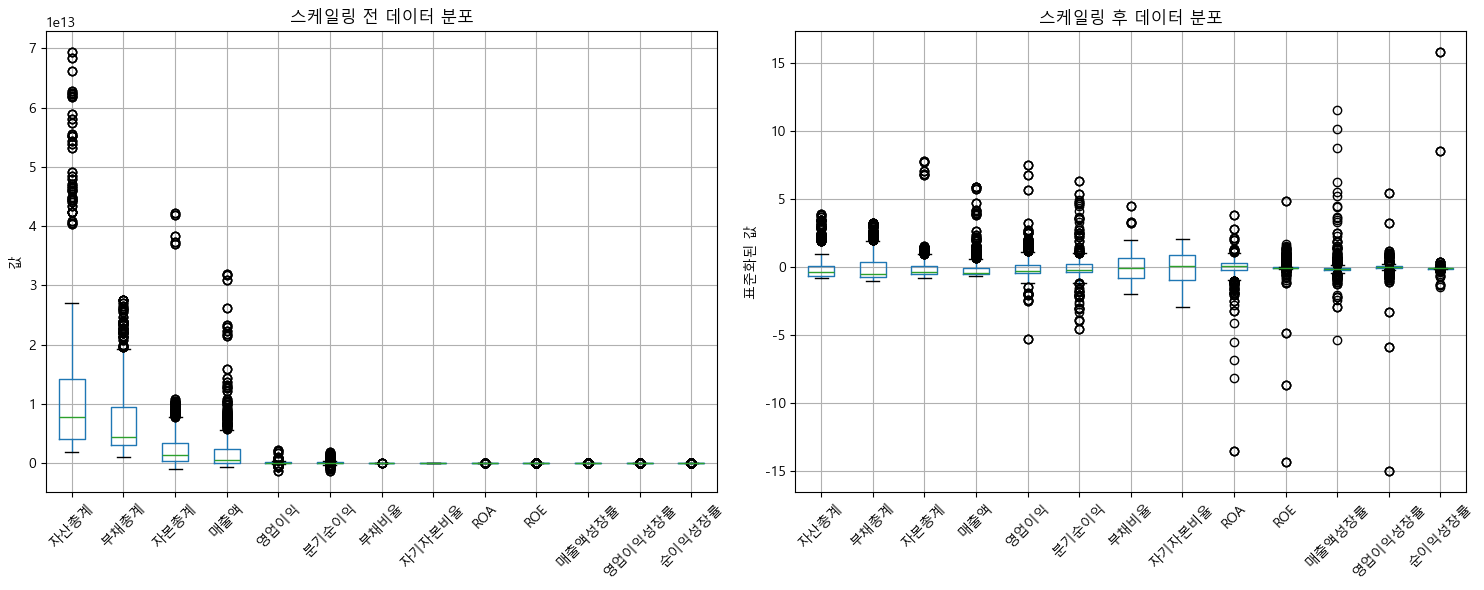


최종 스케일링된 데이터 형태: (1110, 15)
스케일링된 데이터를 'dart_scaled_df_final' 변수에 저장했습니다.

=== 데이터프레임 정렬 ===
기업별, 날짜 순으로 정렬 완료

최종 처리된 DART 데이터 샘플 (정렬 후):
         date corp_name      자산총계      부채총계      자본총계       매출액      영업이익  \
0  2015-10-31     DL이앤씨 -0.059258  0.002598  0.382360 -0.038771 -0.097476   
1  2015-11-30     DL이앤씨 -0.059258  0.002598  0.382360 -0.038771 -0.097476   
2  2015-12-31     DL이앤씨 -0.059258  0.002598  0.382360 -0.038771 -0.097476   
3  2016-01-31     DL이앤씨 -0.040550  0.023559  0.409544 -0.038771 -0.097476   
4  2016-02-29     DL이앤씨 -0.040550  0.023559  0.409544 -0.038771 -0.097476   
5  2016-03-31     DL이앤씨 -0.040550  0.023559  0.409544 -0.038771 -0.097476   
6  2016-04-30     DL이앤씨 -0.037315  0.013165  0.431626 -0.429694 -0.257279   
7  2016-05-31     DL이앤씨 -0.037315  0.013165  0.431626 -0.429694 -0.257279   
8  2016-06-30     DL이앤씨 -0.037315  0.013165  0.431626 -0.429694 -0.257279   
9  2016-07-31     DL이앤씨 -0.050819 -0.032174  0.449458 -0.513465 -0.436582   
10 2016-08-31

In [48]:
# 4단계: StandardScaler로 스케일 조정 (파생변수 포함)
print("=== 4단계: 데이터 스케일링 (파생변수 포함) ===")

# 파생변수가 포함된 데이터 사용
if 'dart_with_all_derived' in locals():
    data_for_scaling = dart_with_all_derived.copy()
    print("✅ 파생변수 포함 데이터 사용")
else:
    data_for_scaling = dart_interpolated_new.copy()
    print("⚠️ 기본 데이터 사용 (파생변수 없음)")

# 날짜와 기업명 컬럼 분리
date_col_new = data_for_scaling['date'].copy() if 'date' in data_for_scaling.columns else None
corp_name_col_new = data_for_scaling['corp_name'].copy() if 'corp_name' in data_for_scaling.columns else None

# 수치형 컬럼만 선택 (날짜, 기업명 제외)
exclude_cols_new = ['date', 'corp_name']
numeric_cols_new = [col for col in data_for_scaling.columns if col not in exclude_cols_new]
numeric_data_new = data_for_scaling[numeric_cols_new].copy()

print(f"스케일링 대상 컬럼: {len(numeric_cols_new)}개")
print(f"컬럼명: {numeric_cols_new}")

# 스케일링 전 통계
print(f"\n스케일링 전 데이터 통계:")
print(numeric_data_new.describe().round(2))

# StandardScaler 적용
from sklearn.preprocessing import StandardScaler
scaler_new = StandardScaler()
scaled_data_new = scaler_new.fit_transform(numeric_data_new)

# 스케일링된 데이터를 DataFrame으로 변환
dart_scaled_df_final = pd.DataFrame(scaled_data_new, columns=numeric_cols_new, index=numeric_data_new.index)

# 날짜와 기업명 컬럼 추가
if date_col_new is not None:
    dart_scaled_df_final.insert(0, 'date', date_col_new)
if corp_name_col_new is not None:
    dart_scaled_df_final.insert(1, 'corp_name', corp_name_col_new)

print(f"\n스케일링 후 데이터 통계:")
scaled_numeric_cols_new = [col for col in dart_scaled_df_final.columns if col not in ['date', 'corp_name']]
print(dart_scaled_df_final[scaled_numeric_cols_new].describe().round(2))

# 스케일링 전후 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 원본 데이터 분포 (박스플롯)
numeric_data_new.boxplot(ax=axes[0], rot=45)
axes[0].set_title('스케일링 전 데이터 분포')
axes[0].set_ylabel('값')

# 스케일링 후 데이터 분포
dart_scaled_df_final[scaled_numeric_cols_new].boxplot(ax=axes[1], rot=45)
axes[1].set_title('스케일링 후 데이터 분포')
axes[1].set_ylabel('표준화된 값')

plt.tight_layout()
plt.show()

print(f"\n최종 스케일링된 데이터 형태: {dart_scaled_df_final.shape}")
print("스케일링된 데이터를 'dart_scaled_df_final' 변수에 저장했습니다.")

# 데이터프레임 정렬: 1. 기업별, 2. 날짜 순
print("\n=== 데이터프레임 정렬 ===")
dart_scaled_df_final = dart_scaled_df_final.sort_values(['corp_name', 'date']).reset_index(drop=True)
print("기업별, 날짜 순으로 정렬 완료")

# 최종 결과 확인
print("\n최종 처리된 DART 데이터 샘플 (정렬 후):")
print(dart_scaled_df_final.head(15))

# 기업명별 데이터 확인
print(f"\n포함된 기업: {dart_scaled_df_final['corp_name'].unique()}")
print(f"기업별 데이터 개수:")
print(dart_scaled_df_final['corp_name'].value_counts())

# 각 기업별 날짜 범위 확인
print(f"\n기업별 날짜 범위:")
for corp in dart_scaled_df_final['corp_name'].unique():
    corp_data = dart_scaled_df_final[dart_scaled_df_final['corp_name'] == corp]
    print(f"{corp}: {corp_data['date'].min().strftime('%Y-%m-%d')} ~ {corp_data['date'].max().strftime('%Y-%m-%d')} ({len(corp_data)}개)")

# 3. ECOS-DART 데이터 통합

전처리 완료된 ECOS 경제지표 데이터와 DART 건설업 재무 데이터를 날짜 기준으로 통합합니다.

In [49]:
# ECOS와 DART 데이터 통합 (파생변수 포함)
print("=== ECOS-DART 데이터 통합 (파생변수 포함) ===")

# 데이터 존재 여부 확인
if 'ecos_scaled_df' not in locals():
    print("⚠️ ECOS 스케일링된 데이터가 없습니다. ECOS 전처리 셀을 먼저 실행해주세요.")
elif 'dart_scaled_df_final' not in locals():
    print("⚠️ DART 스케일링된 데이터가 없습니다. DART 전처리 셀을 먼저 실행해주세요.")
else:
    print("✅ 통합할 데이터 확인 완료")
    print(f"ECOS 데이터: {ecos_scaled_df.shape}")
    print(f"DART 데이터 (파생변수 포함): {dart_scaled_df_final.shape}")
    
    # 파생변수 포함 여부 확인
    derived_vars = ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
    included_derived = [var for var in derived_vars if var in dart_scaled_df_final.columns]
    if included_derived:
        print(f"✅ 포함된 파생변수: {included_derived}")
    else:
        print("⚠️ 파생변수가 포함되지 않았습니다.")
    
    # 날짜 범위 확인
    print(f"\nECOS 날짜 범위: {ecos_scaled_df['date'].min()} ~ {ecos_scaled_df['date'].max()}")
    print(f"DART 날짜 범위: {dart_scaled_df_final['date'].min()} ~ {dart_scaled_df_final['date'].max()}")
    
    # 공통 날짜 범위 찾기
    common_start_date = max(ecos_scaled_df['date'].min(), dart_scaled_df_final['date'].min())
    common_end_date = min(ecos_scaled_df['date'].max(), dart_scaled_df_final['date'].max())
    
    print(f"공통 날짜 범위: {common_start_date} ~ {common_end_date}")
    
    # 공통 날짜 범위로 필터링
    ecos_filtered = ecos_scaled_df[
        (ecos_scaled_df['date'] >= common_start_date) & 
        (ecos_scaled_df['date'] <= common_end_date)
    ].copy()
    
    dart_filtered = dart_scaled_df_final[
        (dart_scaled_df_final['date'] >= common_start_date) & 
        (dart_scaled_df_final['date'] <= common_end_date)
    ].copy()
    
    print(f"\n필터링 후:")
    print(f"ECOS 데이터: {ecos_filtered.shape}")
    print(f"DART 데이터: {dart_filtered.shape}")
    
    # 날짜 기준으로 병합 (DART 데이터에 ECOS 데이터 추가)
    print("\n=== 데이터 병합 수행 ===")
    integrated_data = pd.merge(
        dart_filtered, 
        ecos_filtered, 
        on='date', 
        how='inner'
    )
    
    # 컬럼 순서 조정: 1. corp_name, 2. date, 3. 나머지
    cols = ['corp_name', 'date'] + [col for col in integrated_data.columns if col not in ['corp_name', 'date']]
    integrated_data = integrated_data[cols]
    
    # 기업별, 날짜 순으로 정렬
    integrated_data = integrated_data.sort_values(['corp_name', 'date']).reset_index(drop=True)
    
    print(f"통합 데이터 형태: {integrated_data.shape}")
    print(f"통합 데이터 컬럼 수: {len(integrated_data.columns)}")
    
    # 컬럼 정보 출력
    print(f"\n=== 통합 데이터 컬럼 구성 ===")
    dart_cols = [col for col in dart_filtered.columns if col not in ['date']]
    ecos_cols = [col for col in ecos_filtered.columns if col not in ['date']]
    
    print(f"기본 컬럼 (2개): corp_name, date")
    print(f"DART 재무지표 ({len(dart_cols)-1}개): {[col for col in dart_cols if col != 'corp_name']}")
    print(f"ECOS 경제지표 ({len(ecos_cols)}개): {ecos_cols}")
    
    print(f"\n=== 통합 데이터 샘플 ===")
    print(integrated_data.head(10))
    
    # 기업별 데이터 개수 확인
    print(f"\n=== 기업별 데이터 개수 ===")
    print(integrated_data['corp_name'].value_counts())
    
    print("\n✅ 데이터 통합 완료! 통합 데이터를 'integrated_data' 변수에 저장했습니다.")

=== ECOS-DART 데이터 통합 (파생변수 포함) ===
✅ 통합할 데이터 확인 완료
ECOS 데이터: (119, 20)
DART 데이터 (파생변수 포함): (1110, 15)
✅ 포함된 파생변수: ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']

ECOS 날짜 범위: 2015-10-31 00:00:00 ~ 2025-08-31 00:00:00
DART 날짜 범위: 2015-10-31 00:00:00 ~ 2024-12-31 00:00:00
공통 날짜 범위: 2015-10-31 00:00:00 ~ 2024-12-31 00:00:00

필터링 후:
ECOS 데이터: (111, 20)
DART 데이터: (1110, 15)

=== 데이터 병합 수행 ===
통합 데이터 형태: (1110, 34)
통합 데이터 컬럼 수: 34

=== 통합 데이터 컬럼 구성 ===
기본 컬럼 (2개): corp_name, date
DART 재무지표 (13개): ['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익', '부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
ECOS 경제지표 (19개): ['base_rate', 'ccsi', 'construction_bsi_actual', 'construction_bsi_forecast', 'cpi', 'esi', 'exchange_usd_원_달러종가_15_30', 'housing_lease_price', 'housing_sale_price', 'import_price_비금속광물', 'import_price_철강1차제품', 'leading_index', 'm2_growth', 'market_rate_국고채10년', 'market_rate_국고채3년', 'market_rate_회사채3년_AA_', 'market_rate_회사채3년_BBB_', 'ppi_비금속광물', 'ppi_철강1차제품

In [50]:
# 통합된 데이터 확인
if 'integrated_data' in locals():
    print("=== 통합 데이터 최종 확인 ===")
    print(f"통합 데이터 형태: {integrated_data.shape}")
    print(f"기간: {integrated_data['date'].min()} ~ {integrated_data['date'].max()}")
    print(f"포함 기업: {len(integrated_data['corp_name'].unique())}개")
    
    # 데이터 구조 확인
    print(f"\n=== 데이터 구조 ===")
    print("컬럼 순서:")
    for i, col in enumerate(integrated_data.columns):
        print(f"{i}. {col}")
    
    # 첫 번째 기업의 첫 10개 데이터 확인
    first_corp = integrated_data['corp_name'].iloc[0]
    print(f"\n=== {first_corp} 기업 데이터 샘플 ===")
    first_corp_data = integrated_data[integrated_data['corp_name'] == first_corp].head(10)
    print(first_corp_data[['corp_name', 'date', '매출액', 'base_rate', 'construction_bsi_actual']])
    
    print(f"\n=== 각 기업별 월별 데이터 개수 ===")
    corp_counts = integrated_data['corp_name'].value_counts()
    print(corp_counts)
    
    # 통합 데이터 전체 표시
    print(f"\n=== 통합 데이터 전체 미리보기 ===")
    integrated_data

=== 통합 데이터 최종 확인 ===
통합 데이터 형태: (1110, 34)
기간: 2015-10-31 00:00:00 ~ 2024-12-31 00:00:00
포함 기업: 10개

=== 데이터 구조 ===
컬럼 순서:
0. corp_name
1. date
2. 자산총계
3. 부채총계
4. 자본총계
5. 매출액
6. 영업이익
7. 분기순이익
8. 부채비율
9. 자기자본비율
10. ROA
11. ROE
12. 매출액성장률
13. 영업이익성장률
14. 순이익성장률
15. base_rate
16. ccsi
17. construction_bsi_actual
18. construction_bsi_forecast
19. cpi
20. esi
21. exchange_usd_원_달러종가_15_30
22. housing_lease_price
23. housing_sale_price
24. import_price_비금속광물
25. import_price_철강1차제품
26. leading_index
27. m2_growth
28. market_rate_국고채10년
29. market_rate_국고채3년
30. market_rate_회사채3년_AA_
31. market_rate_회사채3년_BBB_
32. ppi_비금속광물
33. ppi_철강1차제품

=== DL이앤씨 기업 데이터 샘플 ===
  corp_name       date       매출액  base_rate  construction_bsi_actual
0     DL이앤씨 2015-10-31 -0.038771  -0.336370                -0.094226
1     DL이앤씨 2015-11-30 -0.038771  -0.336370                -0.647949
2     DL이앤씨 2015-12-31 -0.038771  -0.336370                -0.647949
3     DL이앤씨 2016-01-31 -0.038771  -0.336370                

In [51]:
integrated_data.to_csv("integrated_data.csv", index=False, encoding='utf-8-sig')

# 파생변수 포함 정보 출력
print("=== 최종 통합 데이터 저장 완료 ===")
print(f"파일명: integrated_data.csv")
print(f"데이터 형태: {integrated_data.shape}")

# 컬럼 구성 정보
if 'integrated_data' in locals():
    # 기본 정보
    basic_cols = ['corp_name', 'date']
    
    # DART 재무지표 (파생변수 제외)
    dart_base_cols = ['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']
    
    # 파생변수
    derived_vars = ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
    included_derived = [var for var in derived_vars if var in integrated_data.columns]
    
    # ECOS 경제지표
    ecos_cols = [col for col in integrated_data.columns 
                if col not in basic_cols + dart_base_cols + derived_vars]
    
    print(f"\n컬럼 구성:")
    print(f"  기본 정보 ({len(basic_cols)}개): {basic_cols}")
    print(f"  기본 재무지표 ({len(dart_base_cols)}개): {dart_base_cols}")
    print(f"  파생 재무지표 ({len(included_derived)}개): {included_derived}")
    print(f"  경제지표 ({len(ecos_cols)}개): {ecos_cols[:5]}... (총 {len(ecos_cols)}개)")
    print(f"  전체 컬럼 수: {len(integrated_data.columns)}개")
    
    if included_derived:
        print(f"\n✅ 파생변수가 성공적으로 포함되었습니다!")
        print(f"💡 머신러닝 모델에서 더 풍부한 재무 분석이 가능합니다.")
    else:
        print(f"\n⚠️ 파생변수가 포함되지 않았습니다. 파생변수 생성 셀을 확인해주세요.")

=== 최종 통합 데이터 저장 완료 ===
파일명: integrated_data.csv
데이터 형태: (1110, 34)

컬럼 구성:
  기본 정보 (2개): ['corp_name', 'date']
  기본 재무지표 (6개): ['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '분기순이익']
  파생 재무지표 (7개): ['부채비율', '자기자본비율', 'ROA', 'ROE', '매출액성장률', '영업이익성장률', '순이익성장률']
  경제지표 (19개): ['base_rate', 'ccsi', 'construction_bsi_actual', 'construction_bsi_forecast', 'cpi']... (총 19개)
  전체 컬럼 수: 34개

✅ 파생변수가 성공적으로 포함되었습니다!
💡 머신러닝 모델에서 더 풍부한 재무 분석이 가능합니다.
